<a href="https://colab.research.google.com/github/Andreher00/ml-project/blob/main/progetto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine learning for cell type classification from single nucleus RNA sequencing data

---



Il sequenziamento dell'RNA a singola cellula  (single cell RNA-Seq) permette
un'analisi approfondita dell'espressione genica e fornisce una
panoramica più dettagliata sulle funzioni cellulari. Tuttavia, il task di classificazione delle cellule in specifiche e ben definite categorie attraverso i dati provienienti dal sequenziamento dell'RNA rimane un problema non banale a causa delle difficoltà nel determinare le differenze specifiche fra tipi cellulari con similarità trascrizionali vicine. Abbiamo esplorato possibili metodi di machine learning per affrontare questo task di classificazione multiclasse, attraverso l'utilizzo di SVM, KNN e Random Forest.
Il Dataset utilizzato è https://www.kaggle.com/datasets/aayush9753/singlecell-rnaseq-data-from-mouse-brain?select=brain_metadata.csv

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive



Il dataset consiste di:
* una matrice di
espressione genica derivante da un organismo modello ovvero il Mus Musculus e riguardante in particolare il tessuto cerebrale. Ogni colonna corrisponde a un gene e ogni riga corrisponde alla singola cellula.
* una tabella di metadati che riporta la descrizione di ogni singola cellula.

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/progettoML/brain_counts.csv.gz')
annotations = pd.read_csv('/content/drive/MyDrive/progettoML/brain_metadata.csv')

In [ ]:
data.shape

(3401, 23434)

In [ ]:
data.head()

,Unnamed: 0,0610005C13Rik,0610007C21Rik,0610007L01Rik,0610007N19Rik,0610007P08Rik,0610007P14Rik,0610007P22Rik,0610008F07Rik,0610009B14Rik,...,Zxdb,Zxdc,Zyg11a,Zyg11b,Zyx,Zzef1,Zzz3,a,l7Rn6,zsGreen_transgene
0,A1.B003290.3_38_F.1.1,0,125,16,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,54,0
1,A1.B003728.3_56_F.1.1,0,0,0,0,0,324,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,A1.MAA000560.3_10_M.1.1,0,348,0,0,0,5,0,0,0,...,0,0,0,0,0,195,0,0,113,0
3,A1.MAA000564.3_10_M.1.1,0,41,36,0,0,24,0,0,0,...,0,0,0,0,125,0,1,0,0,0
4,A1.MAA000923.3_9_M.1.1,0,53,0,0,0,0,0,0,0,...,0,0,0,81,0,0,0,0,0,0


In [ ]:
annotations.head()

,cell,cell_ontology_class,subtissue,mouse.sex,mouse.id,plate.barcode
0,A1.B003290.3_38_F.1.1,astrocyte,Striatum,F,3_38_F,B003290
1,A1.B003728.3_56_F.1.1,astrocyte,Striatum,F,3_56_F,B003728
2,A1.MAA000560.3_10_M.1.1,oligodendrocyte,Cortex,M,3_10_M,MAA000560
3,A1.MAA000564.3_10_M.1.1,endothelial cell,Striatum,M,3_10_M,MAA000564
4,A1.MAA000923.3_9_M.1.1,astrocyte,Hippocampus,M,3_9_M,MAA000923


Si puo notare come il dataset sia fortemente sbilanciato a livello delle singole classi. Abbiamo cercato di risolvere il problema utilizzando il parametro class_weight per ogni algoritmo di machine learning. Grazie a class_weight il peso di classe diventa inversamente proporzionale alla frequenza di classe nei dati di input.

In [ ]:
annotations["cell_ontology_class"].value_counts()

oligodendrocyte                   1574
endothelial cell                   715
astrocyte                          432
neuron                             281
oligodendrocyte precursor cell     203
brain pericyte                     156
Bergmann glial cell                 40
Name: cell_ontology_class, dtype: int64

In [ ]:
data.index = data['Unnamed: 0']

In [ ]:
data = data.drop('Unnamed: 0', axis=1)
# change index name to cell
data.index.name = 'cell'

In [ ]:
data.head()

,0610005C13Rik,0610007C21Rik,0610007L01Rik,0610007N19Rik,0610007P08Rik,0610007P14Rik,0610007P22Rik,0610008F07Rik,0610009B14Rik,0610009B22Rik,...,Zxdb,Zxdc,Zyg11a,Zyg11b,Zyx,Zzef1,Zzz3,a,l7Rn6,zsGreen_transgene
cell,,,,,,,,,,,,,,,,,,,,,
A1.B003290.3_38_F.1.1,0,125,16,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,54,0
A1.B003728.3_56_F.1.1,0,0,0,0,0,324,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A1.MAA000560.3_10_M.1.1,0,348,0,0,0,5,0,0,0,0,...,0,0,0,0,0,195,0,0,113,0
A1.MAA000564.3_10_M.1.1,0,41,36,0,0,24,0,0,0,14,...,0,0,0,0,125,0,1,0,0,0
A1.MAA000923.3_9_M.1.1,0,53,0,0,0,0,0,0,0,0,...,0,0,0,81,0,0,0,0,0,0


In [ ]:
annotations.index = annotations["cell"]

Abbiamo ritenuto opportuno estrarre dai metadati esclusivamente il tipo cellulare ai fini della classificazione multiclasse e inserirlo a livello della matrice di espressione.

In [ ]:
data= data.merge(annotations[['cell_ontology_class']], on='cell', how='inner')

In [ ]:
data.head()

,0610005C13Rik,0610007C21Rik,0610007L01Rik,0610007N19Rik,0610007P08Rik,0610007P14Rik,0610007P22Rik,0610008F07Rik,0610009B14Rik,0610009B22Rik,...,Zxdc,Zyg11a,Zyg11b,Zyx,Zzef1,Zzz3,a,l7Rn6,zsGreen_transgene,cell_ontology_class
cell,,,,,,,,,,,,,,,,,,,,,
A1.B003290.3_38_F.1.1,0,125,16,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,54,0,astrocyte
A1.B003728.3_56_F.1.1,0,0,0,0,0,324,0,0,0,0,...,0,0,0,0,0,0,0,0,0,astrocyte
A1.MAA000560.3_10_M.1.1,0,348,0,0,0,5,0,0,0,0,...,0,0,0,0,195,0,0,113,0,oligodendrocyte
A1.MAA000564.3_10_M.1.1,0,41,36,0,0,24,0,0,0,14,...,0,0,0,125,0,1,0,0,0,endothelial cell
A1.MAA000923.3_9_M.1.1,0,53,0,0,0,0,0,0,0,0,...,0,0,81,0,0,0,0,0,0,astrocyte


In [ ]:
X = data.drop('cell_ontology_class', axis=1)
y = data['cell_ontology_class']

Dividiamo il dataset in training e test, utilizzando la proporzione di default di 0.25 per la dimensione del test set.

In [ ]:
# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y)

Le matrici risultanti da un esperimento di single cell/nucleus RNAseq sono *sparse*, presentano cioè molti 0 dovuti al fatto che per ogni cellula solo una piccola quantità di geni viene rilevata (circa 2000-3000 rispetto ai più di 20000 totali nel genoma). Per questo, per ogni modello abbiamo inserito una feature extraction tramite PCA per ridurre la dimensionalità del dataset alle componenti responsabili per la maggiore varianza, preceduta da standardizzazione. Questo è un passaggio abituale nel preprocessing di dati di scRNAseq.

Per ogni modello definiamo una pipeline, che ci consente di applicare automaticamente il preprocessing al training e al test set evitando il data leakage, cioè l'utilizzo di informazioni presenti nel test set per il training del modello.
Per la determinazione degli iperparametri abbiamo fatto uso della funzione GridSearchCV effettuando una 5-fold cross validation per ogni combinazione di parametri.

#PIPELINE KNN

La K-Nearest Neighbors Classification è un modello non parametrico che per ogni osservazione query, determina la sua classe basandosi sulla classe a cui appartiene la maggioranza delle K osservazioni più vicine ad essa nel training set, secondo una determinata metrica (in questo caso la distanza euclidea).
Gli iperparametri che consideriamo in questo caso sono il numero K di vicini e il loro peso sulla decisione.

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
pca = PCA()
scaler = StandardScaler()
knn = KNeighborsClassifier()
pipe = Pipeline([('scaler', scaler), ('pca', pca), ('knn', knn)])

param_grid = {
  "pca__n_components": [50, 70, 100],
  "knn__n_neighbors": [5, 10, 15],
  "knn__weights": ["uniform", "distance"], # con "uniform" ogni vicino ha lo stesso peso,
                                           # con "distance" il peso di ogni vicino dipende dalla distanza dell'osservazione query
 }

In [ ]:
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1, verbose=3)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA()),
                                       ('knn', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'knn__n_neighbors': [5, 10, 15],
                         'knn__weights': ['uniform', 'distance'],
                         'pca__n_components': [50, 70, 100]},
             verbose=3)

In [ ]:
print("Best parameter (CV score=%0.3f):" % grid.best_score_)
print(grid.best_params_)
print("Score on test set: ", grid.score(X_test, y_test))
estimator = grid.best_estimator_

Best parameter (CV score=0.943):
{'knn__n_neighbors': 10, 'knn__weights': 'distance', 'pca__n_components': 70}
Score on test set:  0.9424206815511164


0.9412819111140817
                                precision    recall  f1-score   support

           Bergmann glial cell       1.00      0.38      0.56        13
                     astrocyte       0.86      0.94      0.90       111
                brain pericyte       0.95      0.95      0.95        43
              endothelial cell       0.99      0.97      0.98       180
                        neuron       0.83      0.92      0.87        59
               oligodendrocyte       0.97      0.95      0.96       398
oligodendrocyte precursor cell       0.90      0.98      0.94        47

                      accuracy                           0.94       851
                     macro avg       0.93      0.87      0.88       851
                  weighted avg       0.95      0.94      0.94       851



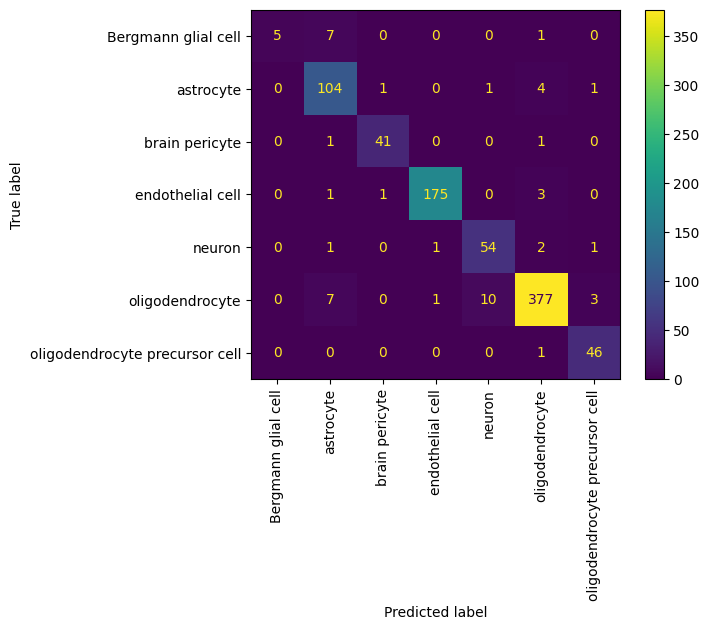

In [ ]:
y_pred = estimator.predict(X_test)
from sklearn.metrics import f1_score, ConfusionMatrixDisplay, classification_report
print(f1_score(y_test, y_pred, average='weighted'))
print(classification_report(y_test,y_pred))
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, xticks_rotation='vertical')

In [ ]:
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, xticks_rotation='vertical', normalize='true')



# PIPELINE SVM

Una Support Vector Machine cerca di costruire un iperpiano nello spazio delle feature che abbia distanza massima dal punto più vicino nel training set (margine funzionale). Dataset non linearmente separabili possono diventarlo applicando una funzione nonlineare a ogni coppia di osservazioni (*kernel*).
Gli iperparametri che consideriamo sono il parametro di regolarizzazione C, la funzione kernel, il grado del polinomio nel caso di kernel polinomiale e il peso assegnato agli errori

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

pca = PCA(n_components=50)
scaler = StandardScaler()
svm = SVC()
pipe = Pipeline([('scaler', scaler), ('pca', pca), ('svm', svm)])

param_grid = {
	"svm__C": [0.01, 0.05, 0.1],
	"svm__kernel": ["linear", "rbf", "poly"],
	# "svm__degree": range(2, 6),
	"svm__class_weight": [None, "balanced"]      # Impostando questo parametro su "balanced" l'errore nella predizione di un elemento ha un peso
                                               # inversamente proporzionale alla frequenza della sua classe nel training set
}


In [ ]:
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1, verbose=3)
grid.fit(X_train, y_train)


Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA(n_components=50)),
                                       ('svm', SVC())]),
             n_jobs=-1,
             param_grid={'svm__C': [0.01, 0.05, 0.1],
                         'svm__class_weight': [None, 'balanced'],
                         'svm__kernel': ['linear', 'rbf', 'poly']},
             verbose=3)

In [ ]:
print("Best parameter (CV score=%0.3f):" % grid.best_score_)
print(grid.best_params_)

Best parameter (CV score=0.944):
{'svm__C': 0.1, 'svm__class_weight': None, 'svm__kernel': 'linear'}


In [ ]:
grid.score(X_test, y_test)

0.9553466509988249

In [ ]:
estimator = grid.best_estimator_

0.9557057142440233
                                precision    recall  f1-score   support

           Bergmann glial cell       0.79      0.85      0.81        13
                     astrocyte       0.94      0.91      0.92       111
                brain pericyte       0.88      0.98      0.92        43
              endothelial cell       0.99      0.98      0.98       180
                        neuron       0.88      0.97      0.92        59
               oligodendrocyte       0.98      0.95      0.97       398
oligodendrocyte precursor cell       0.92      0.98      0.95        47

                      accuracy                           0.96       851
                     macro avg       0.91      0.94      0.93       851
                  weighted avg       0.96      0.96      0.96       851



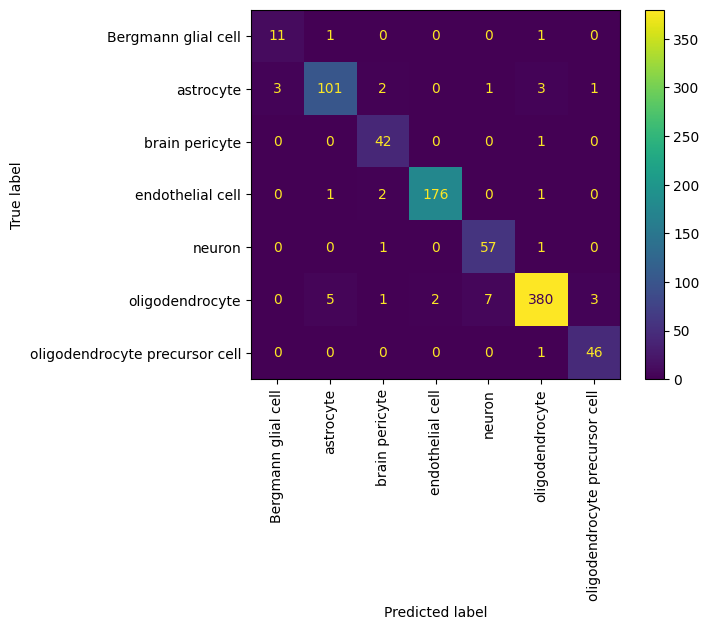

In [ ]:
y_pred = estimator.predict(X_test)
from sklearn.metrics import f1_score, ConfusionMatrixDisplay, classification_report
print(f1_score(y_test, y_pred, average='weighted'))
print(classification_report(y_test,y_pred))
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, xticks_rotation='vertical')

In [ ]:
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, xticks_rotation='vertical', normalize='true')

# PIPELINE RANDOM FOREST

Una Random Forest è un modello ensemble formato da una combinazione (bagging) di alberi decisionali. Ogni albero viene addestrato su un campione selezionato tramite bootstrap dal training set e la predizione finale è data dalla classe predetta dalla maggioranza degli alberi.
Gli iperparametri che consideriamo sono il numero di alberi e il peso degli errori.

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

pca = PCA()
scaler = StandardScaler()
rfc = RandomForestClassifier()
pipe = Pipeline([('scaler', scaler), ('pca', pca), ('rfc', rfc)])

param_grid = {
    "pca__n_components": [50, 70, 100],
    "rfc__n_estimators": [100, 150, 200],
    "rfc__class_weight": [None, "balanced"] # Impostando questo parametro su "balanced" l'errore nella predizione di un elemento ha un peso
                                            # inversamente proporzionale alla frequenza della sua classe nel training set
}

In [ ]:
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1, verbose=3)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA()),
                                       ('rfc', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'pca__n_components': [50, 70, 100],
                         'rfc__class_weight': [None, 'balanced'],
                         'rfc__n_estimators': [100, 150, 200]},
             verbose=3)

In [ ]:
print("Best parameter (CV score=%0.3f):" % grid.best_score_)
print(grid.best_params_)

Best parameter (CV score=0.949):
{'pca__n_components': 100, 'rfc__class_weight': None, 'rfc__n_estimators': 200}


In [ ]:
grid.score(X_test, y_test)

0.9506462984723855

In [ ]:

estimator = grid.best_estimator_

In [ ]:
y_pred = estimator.predict(X_test)
from sklearn.metrics import f1_score, confusion_matrix
print(f1_score(y_test, y_pred, average='weighted'))
print(classification_report(y_test,y_pred))

0.9507690710886455
                                precision    recall  f1-score   support

           Bergmann glial cell       1.00      0.69      0.82        13
                     astrocyte       0.91      0.95      0.93       111
                brain pericyte       1.00      0.91      0.95        43
              endothelial cell       0.99      0.98      0.99       180
                        neuron       0.84      0.90      0.87        59
               oligodendrocyte       0.96      0.95      0.96       398
oligodendrocyte precursor cell       0.87      0.98      0.92        47

                      accuracy                           0.95       851
                     macro avg       0.94      0.91      0.92       851
                  weighted avg       0.95      0.95      0.95       851



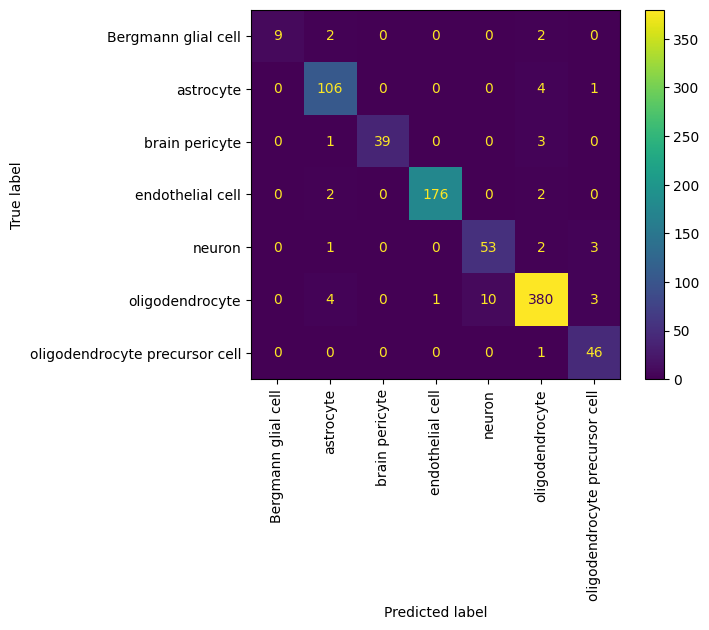

In [ ]:
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, xticks_rotation='vertical')

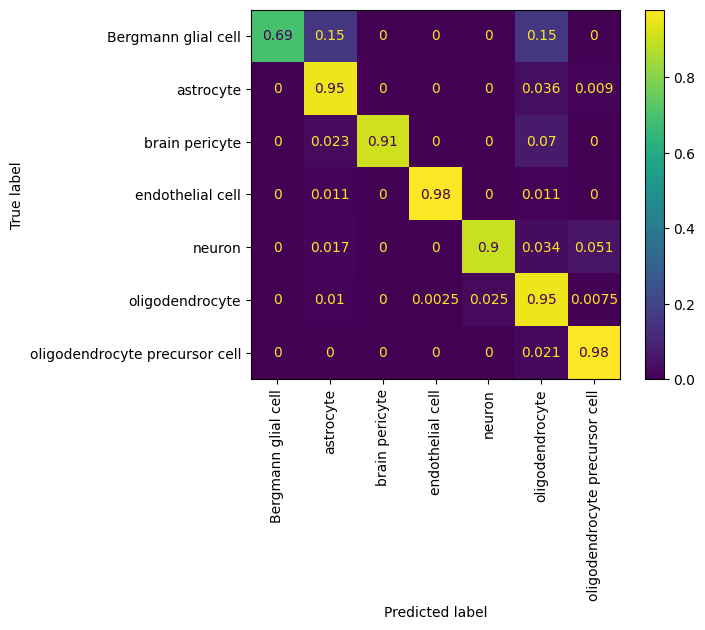

In [ ]:
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, xticks_rotation='vertical', normalize='true')

# DATASET WITHOUT THE CELL TYPE ='BERGMANN GLIAL CELL'

Abbiamo ritenuto opportuno eliminare dal dataset tutti gli elementi classificati come 'Bergman Glial Cell' data l'esigua quantità di elementi e di conseguenza una qualità della predizione pessima rispetto alle altre classi. Riutilizzando SVM sulle restanti classi, notiamo un lieve miglioramento dell'accuracy score.

In [ ]:
data = data[data.cell_ontology_class != 'Bergmann glial cell']
data.shape

(3361, 23434)

In [ ]:
X = data.drop('cell_ontology_class', axis=1)
y = data['cell_ontology_class']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y)


## PIPELINE SVM

In [ ]:
pca = PCA(n_components=50)
scaler = StandardScaler()
svm = SVC()
pipe = Pipeline([('scaler', scaler), ('pca', pca), ('svm', svm)])

param_grid = {
	"svm__C": [0.01, 0.05, 0.1],
	"svm__kernel": ["linear", "rbf", "poly"],
	# "svm__degree": range(2, 6), # degree for polynomial kernel
	"svm__class_weight": [None, "balanced"]
}

In [ ]:
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1, verbose=3)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA(n_components=50)),
                                       ('svm', SVC())]),
             n_jobs=-1,
             param_grid={'svm__C': [0.01, 0.05, 0.1],
                         'svm__class_weight': [None, 'balanced'],
                         'svm__kernel': ['linear', 'rbf', 'poly']},
             verbose=3)

In [ ]:
print("Best parameter (CV score=%0.3f):" % grid.best_score_)
print(grid.best_params_)

Best parameter (CV score=0.954):
{'svm__C': 0.05, 'svm__class_weight': None, 'svm__kernel': 'linear'}


In [ ]:
grid.score(X_test, y_test)

0.9643281807372176

In [ ]:
estimator = grid.best_estimator_

0.9645595251204321
                                precision    recall  f1-score   support

                     astrocyte       0.95      0.96      0.95       117
                brain pericyte       0.91      1.00      0.95        41
              endothelial cell       0.98      0.98      0.98       172
                        neuron       0.88      0.93      0.90        61
               oligodendrocyte       0.99      0.96      0.97       399
oligodendrocyte precursor cell       0.94      0.96      0.95        51

                      accuracy                           0.96       841
                     macro avg       0.94      0.97      0.95       841
                  weighted avg       0.97      0.96      0.96       841



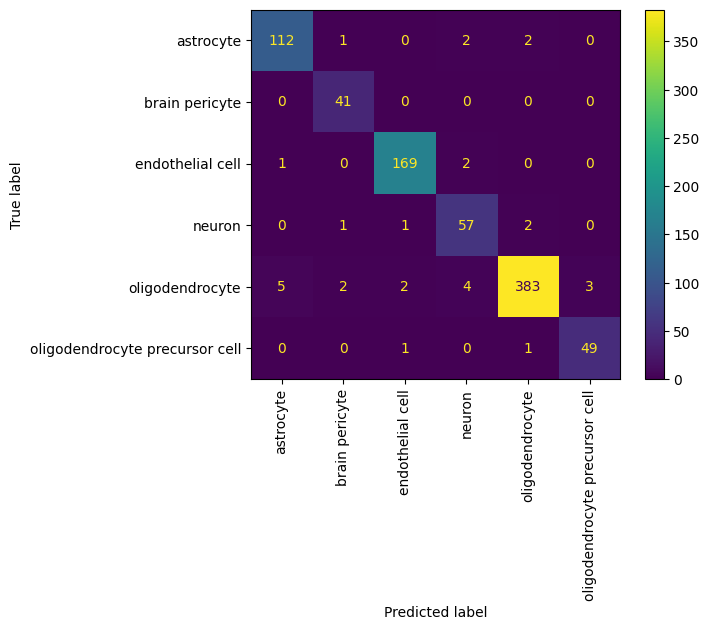

In [ ]:
y_pred = estimator.predict(X_test)
from sklearn.metrics import f1_score, ConfusionMatrixDisplay, classification_report
print(f1_score(y_test, y_pred, average='weighted'))
print(classification_report(y_test,y_pred))
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, xticks_rotation='vertical')

In [ ]:
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, xticks_rotation='vertical', normalize='true')

## Conclusioni

Il progetto dimostra che è possibile una classificazione dei tipi cellulari tramite gli algoritmi di machine learning qui utilizzati. Dai risultati si evince una migliore performance dei modelli nel momento in cui attuiamo una feature extraction tramite PCA e eseguiamo una ricerca su griglia dei migliori parametri del modello. Il risultante workflow potrebbe non essere limitato esclusivamente a questo dataset ma ha il potenziale di produrre modelli di classificazione per qualsiasi tipo di cellula in qualsiasi tessuto e specie. Per concludere, la crescente applicazione di tecnologie di sequenziamento high throughput single-cell e l'analisi tramite modelli avanzati di machine learning possono rivoluzionare la nostra comprensione di come l'eterogeneità cellulare contribuisce alle funzioni tessuto-specifiche.